Data taken from http://physics.nist.gov/PhysRefData/Xcom/html/xcom1.html
More information: http://physics.nist.gov/PhysRefData/XrayMassCoef/chap3.html

In [101]:
from __future__ import print_function

In [19]:
import matplotlib
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
import Core.system_of_units as units

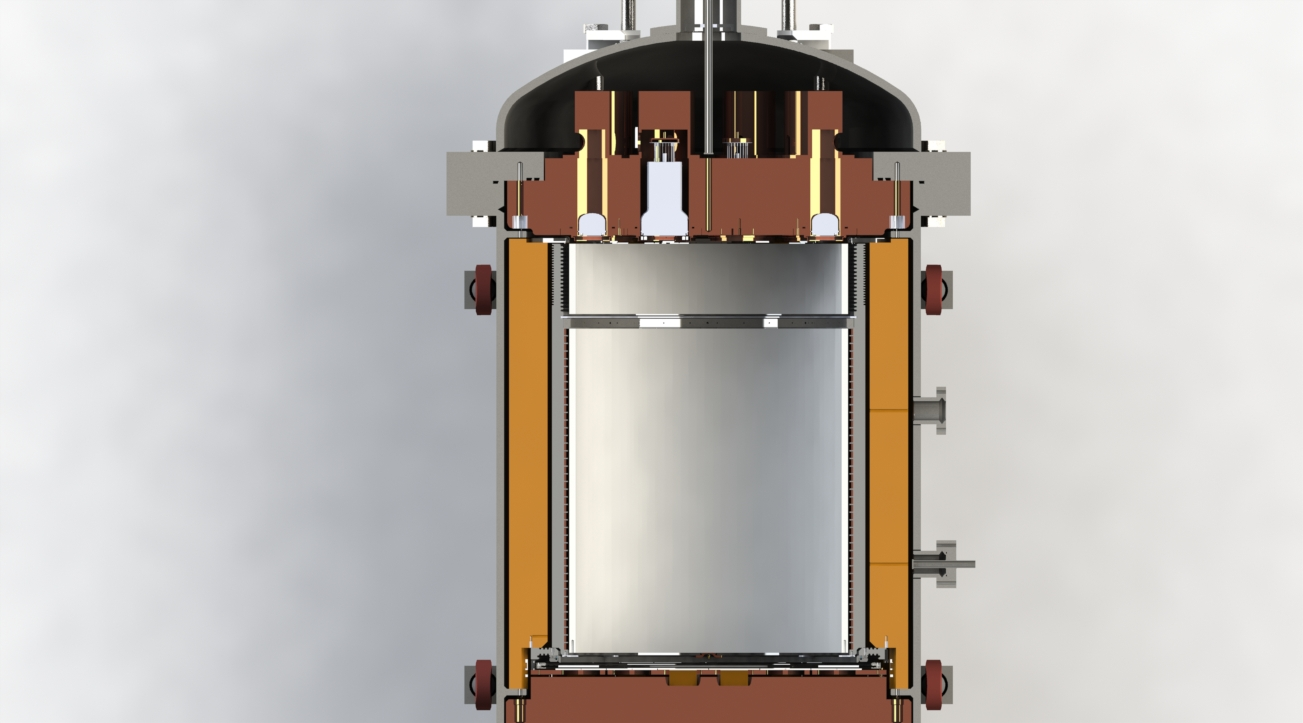

In [102]:
Image(filename='NEW_cut_top1.jpg') 

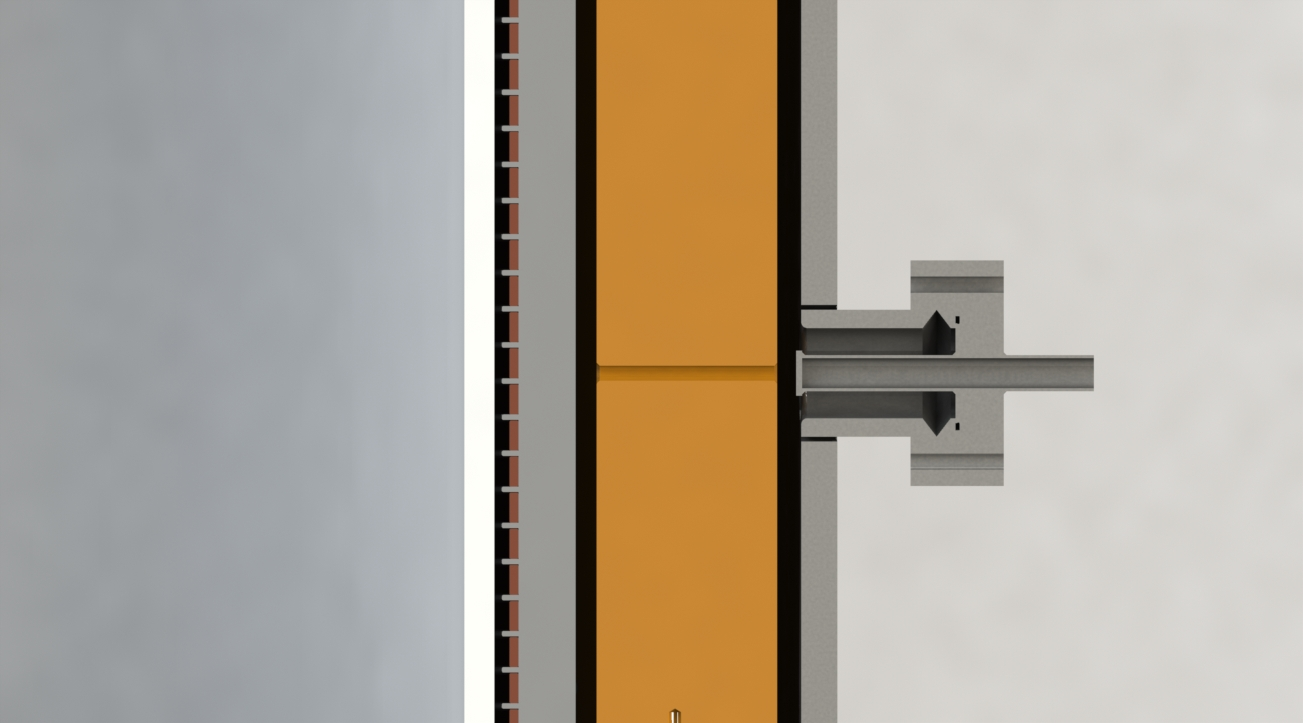

In [105]:
Image(filename='sourceport1.jpg') 

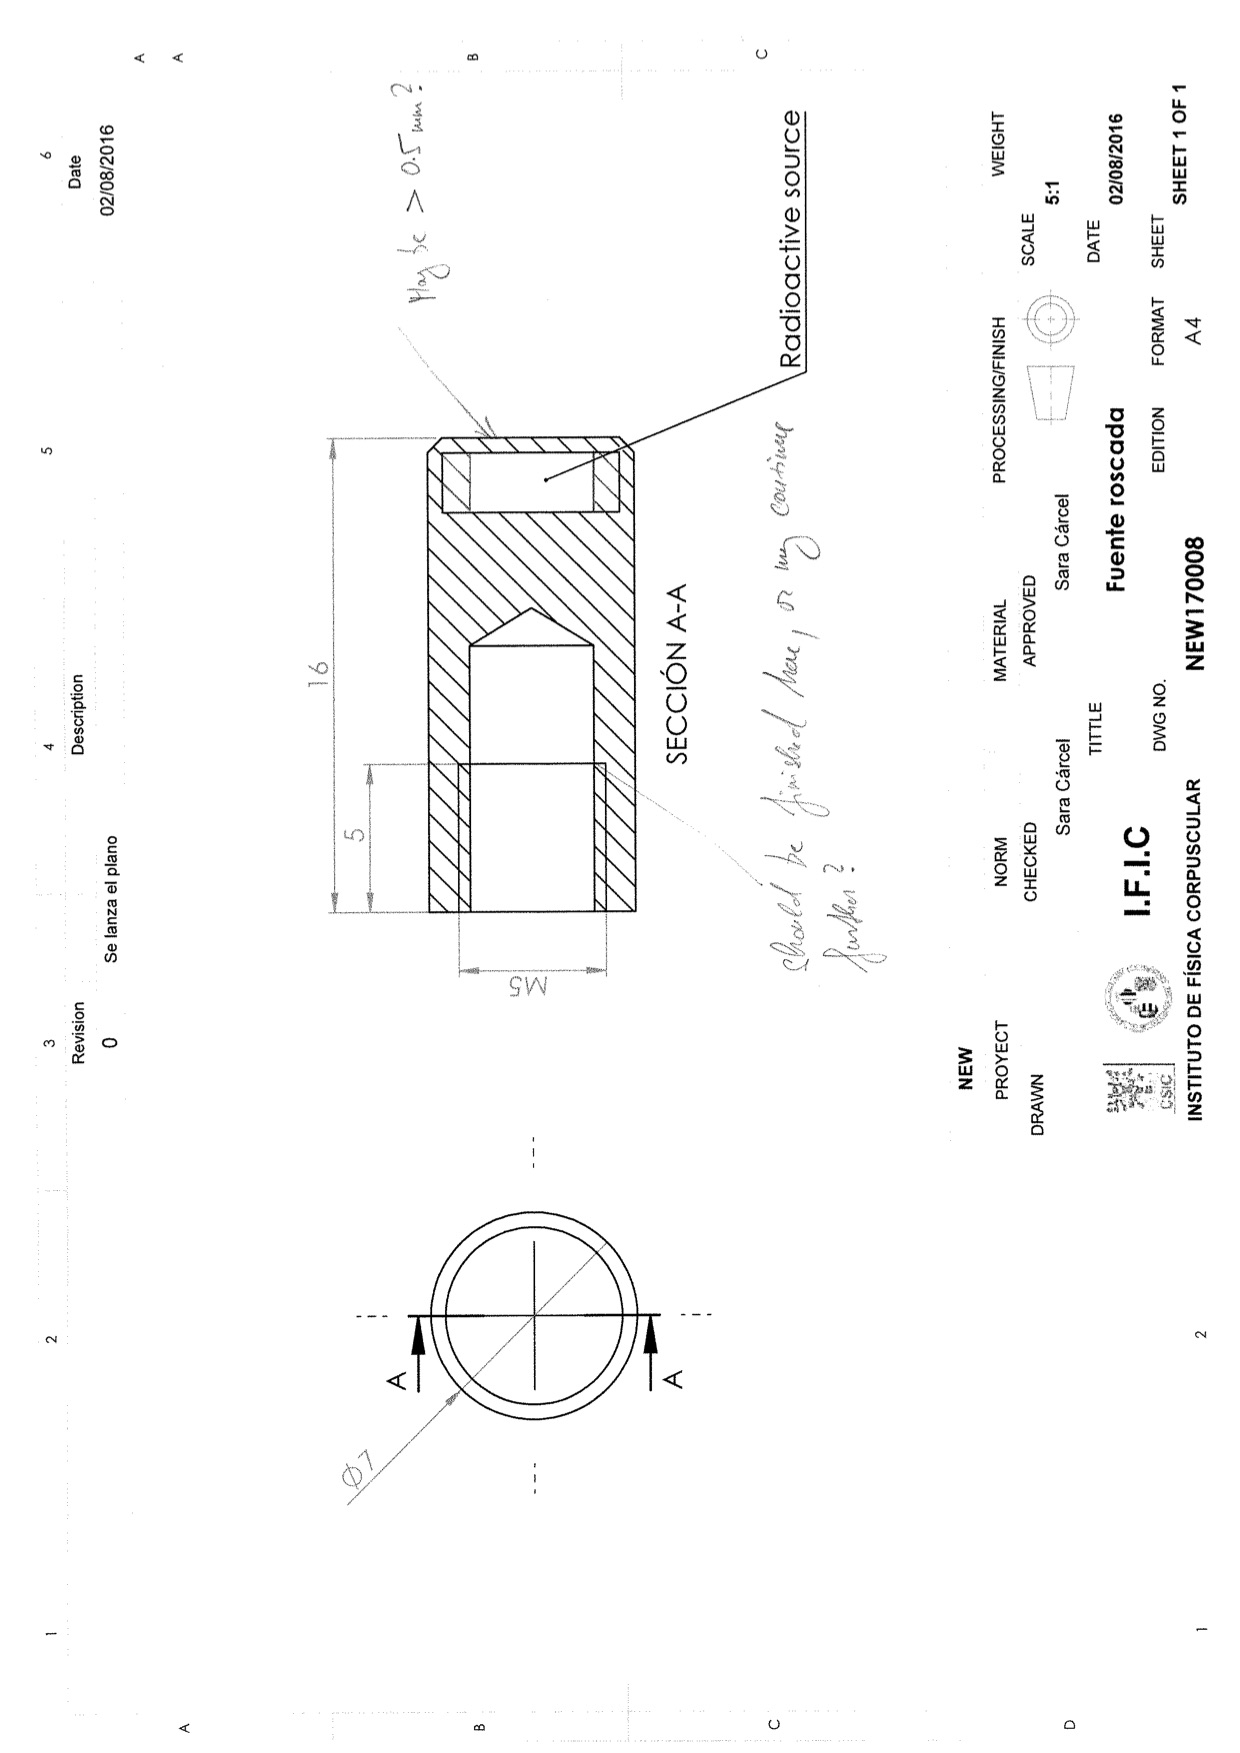

In [106]:
Image(filename='source.jpg') 

In [109]:
d_s = 7. * units.mm
l_s = 16. * units.mm
print('source is a cilinder of length = {} mm and diameter = {} mm'.format(
    l_s/units.mm, d_s/units.mm))

source is a cilinder of length = 16.0 mm and diameter = 7.0 mm


In [115]:
d_cu = 7. * units.mm
l_cu = 60. * units.mm
r_cu = d_cu/2.
print('diameter of copper port = {} mm copper thickness = {} mm'.format(
    d_cu/units.mm, l_cu/units.mm))

diameter of copper port = 7.0 mm copper thickness = 60.0 mm


In [116]:
l_s_xe = 104. * units.mm
l_tube = 128.2 * units.mm
print('distance source to xenon volume = {} mm length of source holder = {} mm'.format(
    l_s_xe/units.mm, l_tube/units.mm))

distance source to xenon volume = 104.0 mm length of source holder = 128.2 mm


In [118]:
theta_c = np.arcsin(r_cu/l_cu)
print('opening angle with source in nearest position = {} rads'.format(
    theta_c))

opening angle with source in nearest position = 0.0583664666556 rads


In [125]:
def opening_angle(r_cu, z_s):
    """
    Computes de opening angle for a source located at a distance z_s of the copper 
    r_cu is the radious of the copper channel
    """
    return np.arcsin(r_cu/z_s)

In [146]:
attXe = pd.read_table('xe.txt',index_col=False)

In [148]:
attXe = pd.read_table('xe.txt',index_col=False)
attXe['Photoelectric'] = attXe['Photoelectric'] * units.cm2/units.g
attXe['Compton'] = attXe['Compton'] * units.cm2/units.g
attXe['Energy'] = attXe['Energy'] * units.MeV

In [149]:
attCu = pd.read_table('cu.txt',index_col=False)

In [180]:
attCu['Energy'] = attCu['Energy'] * units.MeV
attCu['Total'] = attCu['Total'] * units.cm2/units.g

In [181]:
class XeInt:
    """
    Computes the interaction of photons in xenon as a function of energy
    """
    
    def __init__(self, attXe, p):
        """
        Init takes an instance of attXe data frame and the pressure ssumed to be in bars, 
        e.g, do not multiply by units.
        """
        energy = attXe.Energy.values
        compton = attXe.Compton.values
        photo = attXe.Photoelectric.values
        
        self.fc = interpolate.interp1d(energy, compton)
        self.fp = interpolate.interp1d(energy, photo)
        
        self.xrho = XeRho()
        self.p = p
        self.rho = self.xrho.rho(self.p) 
        
    def lambda_compton(self, energy):
        """
        input: energy 
        returns: attenuation length for compton in units of distance^-1
        """
        return self.fc(energy) * self.rho  # (cm2/g) * (g/cm3) -> L^-1 
    
    def lambda_photo(self, energy):
        """
        input: energy 
        returns: attenuation length for photoelectric in units of distance^-1
        """
        return self.fp(energy) * self.rho  #interpolation units
    
    def transmitted_compton(self, energy, z):
        """
        transmitted beam after a distance z (only taking into account compton)
        """
        return np.exp(-self.lambda_compton(energy) * z)
    
    def transmitted_photo(self, energy, z):
        """
        transmitted beam after a distance z (only taking into account photo)
        """
        return np.exp(-self.lambda_photo(energy) * z)
    
    def int_compton(self, energy, z):
        """
        interaction fraction after a distance z (only taking into account compton)
        """
        return 1. - self.transmitted_compton(energy, z)
    
    def int_photo(self, energy, z):
        """
        interaction fraction after a distance z (only taking into account photo)
        """
        return 1. - self.transmitted_photo(energy, z)

    

In [182]:
class CuInt:
    """
    Computes the interaction of photons in Cu as a function of energy
    """
    
    def __init__(self, attCu, rho_cu = 8.92 * units.g/units.cm3):
        """
        Init takes an instance of attCu data frame
        """
        energy = attCu.Energy.values
        total = attCu.Total.values
        
        self.fc = interpolate.interp1d(energy, total)
        self.rho = rho_cu
        
    def lambda_total(self, energy):
        """
        input: energy 
        returns: attenuation length  in units of distance^-1
        """
        return self.fc(energy) * self.rho  # (cm2/g) * (g/cm3) -> L^-1 
    
    def transmitted_total(self, energy, z):
        """
        transmitted beam after a distance z 
        """
        return np.exp(-self.lambda_total(energy) * z)
    
    def int_total(self, energy, z):
        """
        interaction fraction after a distance z 
        """
        return 1. - self.transmitted_total(energy, z)
    
   
    

In [183]:
class XeRho:
    """
    Computes the density of xenon as a function of pressure
    """
    
    def __init__(self):
        x = np.array([1,5,10,20])
        y = np.array([5.290 * units.kg/units.m3,
                      27.01 * units.kg/units.m3,
                      55.55 * units.kg/units.m3,
                      118.36 * units.kg/units.m3])
        self.f = interpolate.interp1d(x, y)
        
    def rho(self, p):
        """
        input: pressure assumed to be in bars, e.g, do not multiply by units.
        returns: density in system of units (SOU)
        """
        return self.f(p)

In [94]:
ActNaSource = 750 * units.kBq

In [97]:
print('number of photons emitted by source per second = {}'.format(
       ActNaSource * units.second))

number of photons emitted by source per second = 750000.0


In [119]:
print('number of photons emitted by source in one DAQ window (1.2 ms) = {}'.format(
       ActNaSource* 1.2 * units.ms ))

number of photons emitted by source in one DAQ window (1.2 ms) = 900.0


In [120]:
print('number of photons emitted by source in one DAQ window (1.2 ms) within critical angle = {}'.format(
       ActNaSource* 1.2 * units.ms * theta_c * 2 * np.pi))

number of photons emitted by source in one DAQ window (1.2 ms) within critical angle = 330.05459315


In [81]:
xrho = XeRho()

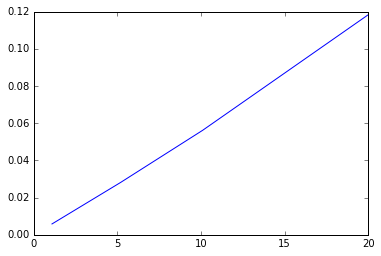

In [189]:
l =range(11,201)
y = np.array([xrho.rho(z/10.) for z in l])
p = np.array(l)/10.
rho = np.array(y) /(units.g/units.cm3)
plt.plot(p, rho)


In [190]:
for i in range(1,11):
    print('density at {} bar in g/cm3 = {}'.format(i, xrho.rho(i*1.)/(units.g/units.cm3)))

density at 1 bar in g/cm3 = 0.00529
density at 2 bar in g/cm3 = 0.01072
density at 3 bar in g/cm3 = 0.01615
density at 4 bar in g/cm3 = 0.02158
density at 5 bar in g/cm3 = 0.02701
density at 6 bar in g/cm3 = 0.032718
density at 7 bar in g/cm3 = 0.038426
density at 8 bar in g/cm3 = 0.044134
density at 9 bar in g/cm3 = 0.049842
density at 10 bar in g/cm3 = 0.05555


In [191]:
xatt = XeInt(attXe, 7.)

In [192]:
xcu = CuInt(attCu)

In [193]:
x = range(1,101)
y = [xcu.transmitted_total(511 * units.keV, z * units.mm) for z in x]

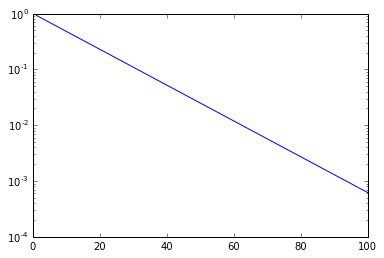

In [175]:
plt.semilogy(x,y)

In [194]:
print(' for rho = 7 bar, e = 511 keV, l_compton = {} cm^-1 , l_photo = {} cm^-1'.format(
       xatt.lambda_compton(511 * units.keV) * units.cm, xatt.lambda_photo(511 * units.keV) * units.cm))

print(' for l = 432 mm, e = 511 keV, t_compton = {}  t_photo = {} '.format(
       xatt.transmitted_compton(511 * units.keV, 432 * units.mm), 
       xatt.transmitted_photo(511 * units.keV, 432. * units.cm)))

print(' for l = 432, e = 511 keV, i_compton = {}  i_photo = {} '.format(
       xatt.int_compton(511 * units.keV, 432. * units.cm), 
       xatt.int_photo(511 * units.keV, 432. * units.cm)))

 for rho = 7 bar, e = 511 keV, l_compton = 0.002693066997 cm^-1 , l_photo = 0.00077063343 cm^-1
 for l = 432 mm, e = 511 keV, t_compton = 0.890172073199  t_photo = 0.716832095841 
 for l = 432, e = 511 keV, i_compton = 0.68757940644  i_photo = 0.283167904159 


### Interactions

In [99]:
print('number of photoelectric interactions in one DAQ window (1.2 ms) = {}'.format(
       ActNaSource* 1.2 * units.ms * xatt.int_photo(511 * units.keV, 50. * units.cm)))

number of photoelectric interactions in one DAQ window (1.2 ms) = 34.0188930891


In [100]:
print('number of compton interactions in one DAQ window (1.2 ms) = {}'.format(
       ActNaSource* 1.2 * units.ms * xatt.int_compton(511 * units.keV, 50. * units.cm)))

number of compton interactions in one DAQ window (1.2 ms) = 113.383045853


In [197]:
print('number of photoelectric interactions in one DAQ window (1.2 ms) within critical angle = {}'.format(
       ActNaSource* 1.2 * units.ms * xatt.int_photo(511 * units.keV, 432. * units.mm * theta_c * 2 * np.pi)))
print('number of compton interactions in one DAQ window (1.2 ms) within critical angle = {}'.format(
       ActNaSource* 1.2 * units.ms * xatt.int_compton(511 * units.keV, 432. * units.mm * theta_c * 2 * np.pi)))

number of photoelectric interactions in one DAQ window (1.2 ms) within critical angle = 10.9211645573
number of compton interactions in one DAQ window (1.2 ms) within critical angle = 37.5910958184


In [179]:

print('Activity source (gammas per second) = {}'.format( ActNaSource * 1.2 * units.second))

for d in range(0, 10):
    print('-------------------------------------------------------')
    act = ActNaSource * 1.2 * units.second * xcu.transmitted_total(511 * units.keV, float(d) * units.cm)
    print('gammas after cupper insert of thickness = {} mm = {}'.format(
           float(d), act))
    act2 = ActNaSource * 1.2 * units.ms * xcu.transmitted_total(511 * units.keV, float(d) * units.cm)
    theta_c = opening_angle(r_cu, l_cu)
    print('number of photoelectric interactions per second within critical angle = {}'.format(
       act * xatt.int_photo(511 * units.keV, 432. * units.mm * theta_c * 2 * np.pi)))
    print('number of photoelectric interactions per DAQ window (1.2 ms) within critical angle = {}'.format(
       act2 * xatt.int_photo(511 * units.keV, 432. * units.mm * theta_c * 2 * np.pi)))
    print('number of compton interactions per DAQ window (1.2 ms) within critical angle = {}'.format(
       act2 * xatt.int_compton(511 * units.keV, 432. * units.mm * theta_c * 2 * np.pi)))

Activity source (gammas per second) = 900000.0
-------------------------------------------------------
gammas after cupper insert of thickness = 0.0 mm = 900000.0
number of photoelectric interactions per second within critical angle = 10921.1645573
number of photoelectric interactions per DAQ window (1.2 ms) within critical angle = 10.9211645573
number of compton interactions per DAQ window (1.2 ms) within critical angle = 37.5910958184
-------------------------------------------------------
gammas after cupper insert of thickness = 1.0 mm = 429944.62414
number of photoelectric interactions per second within critical angle = 5217.21776749
number of photoelectric interactions per DAQ window (1.2 ms) within critical angle = 5.21721776749
number of compton interactions per DAQ window (1.2 ms) within critical angle = 17.9578772918
-------------------------------------------------------
gammas after cupper insert of thickness = 2.0 mm = 205391.533141
number of photoelectric interactions per

#### Since we are biasing towards photoelectric (e.g, we trigger only when there is a photoelectric interaction), the probability of having a compton (or another photoelectric) in the window is very low once we shield enough. 9 mm of copper should be enough to keep a high rate and no pileup.